In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch

In [226]:
aud = torchaudio.load('PhysioNet/training/training-a/a0002.wav')
states_df = pd.read_csv('PhysioNet/training/training-a/a0002.csv', header=None)
states = states_df[0].to_numpy()

In [227]:
def resample(aud, newsr):

        #Resample the audio to the newsr frequency

        sig, sr = aud
        
        if(sr == newsr):
            return((sig, sr))

        num_channels = sig.shape[0]
        resig_fn = torchaudio.transforms.Resample(sr, newsr)
        resig = resig_fn(sig[:1, :])
        if(num_channels > 1):
            retwo_fn = torchaudio.transforms.Resample(sr, newsr)
            retwo = retwo_fn(sig[1:, :])
            resig = torch.cat([resig, retwo])

        return((resig, newsr))

In [228]:
aud = resample(aud, 1000)

In [229]:
def visualizeAudio(aud, states=[], trim=None):
    sig, sr = aud

    #trimming the signal
    disp = sig[0]
    if(trim!=None):
        disp = sig[0][:trim]
        if(len(states) != 0):
            states = states[:trim]

    if(len(states) != 0):
        s1_states = np.ma.masked_where(states != 1, disp)
        systole_states = np.ma.masked_where(states != 2, disp)
        s2_states = np.ma.masked_where(states != 3, disp)
        diastole_states = np.ma.masked_where(states != 4, disp)

    duration = disp.shape[0]
    time = np.linspace(0, duration/sr, duration)
    plt.figure(figsize=(15, 5))
    if(len(states) != 0):
        plt.plot(time, s1_states, label='S1')
        plt.plot(time, systole_states, label='Systole')
        plt.plot(time, s2_states, label='S2')
        plt.plot(time, diastole_states, label='Diastole')
    else:
        plt.plot(time, disp, label='Audio')
    plt.title('Audio Plot')
    plt.ylabel('signal wave')
    plt.xlabel('time (s)')
    plt.legend()
    plt.show()


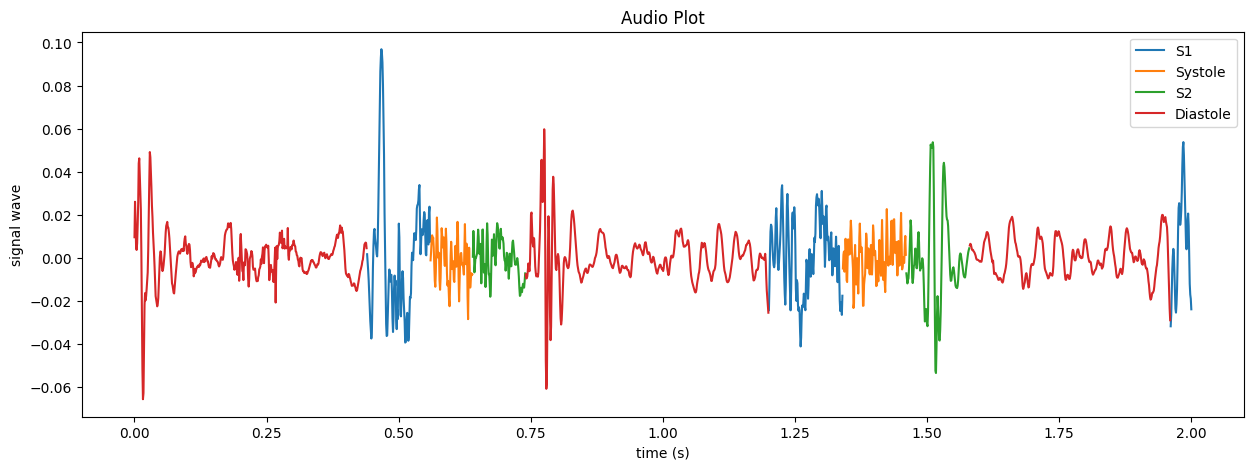

In [237]:
visualizeAudio(aud, states,2000)

In [231]:
def getCycles(states):
    cycles = []
    debounce = False
    previous = None
    sig_len = states.shape[0]
    for i in range(sig_len):
        if (states[i] == 1 and debounce == False):
            if(previous != None):
                cycles.append([previous, i-1])
            previous = i
            debounce = True
        elif (states[i] == 4 and i == sig_len-1):
            if(previous != None):
                cycles.append([previous, i])
        elif (states[i] != 1 and debounce == True):
            debounce = False
    return cycles
    

In [232]:
cycles = getCycles(states)
print(cycles)

[[440, 1199], [1200, 1959], [1960, 2719], [2720, 3479], [3480, 4239], [4240, 4999], [5000, 5739], [5740, 6539], [6540, 7279], [7280, 8039], [8040, 8839], [8840, 9599], [9600, 10359], [10360, 11099], [11100, 11919], [11920, 12679], [12680, 13479], [13480, 14259], [14260, 15039], [15040, 15819], [15820, 16599], [16600, 17479], [17480, 18159], [18160, 18939], [18940, 19699], [19700, 20459]]


In [233]:
def extractCyles(aud, cycles):
    sig, sr = aud
    c_signals = []
    for i, c in enumerate(cycles):
        c_sig = sig[0][c[0]:c[1]]
        c_signals.append(c_sig.unsqueeze(0))
    return(c_signals)

In [234]:
c_signals = extractCyles(aud, cycles)

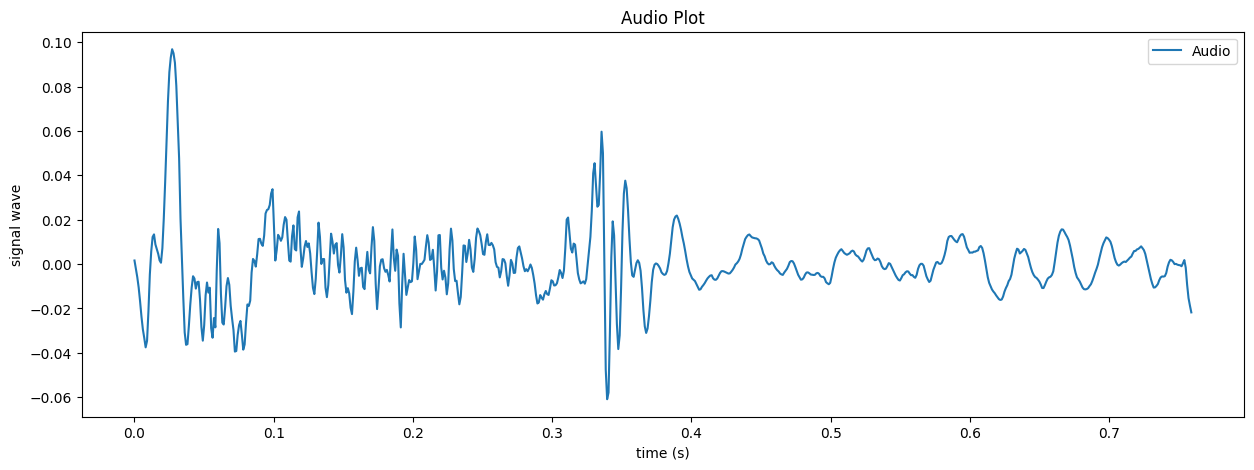

In [238]:
visualizeAudio((c_signals[0], 1000))

In [239]:
max_duration = 0
for i, c in enumerate(cycles):
    if(c[1] - c[0] > max_duration):
        max_duration = c[1] - c[0]
print(max_duration)

879
